In [3]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings
import pickle

from itertools import cycle



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# Import paths from pipeline_config for multi-machine portability
from pipeline_config import config, project_dir_path, temp_files_path

# Dataset configuration
dataset_name = 'traintest_data7.pkl'


import torch
import pickle
import numpy as np

# Load data
with open(temp_files_path + dataset_name, 'rb') as f:
    X_train, X_test, period_train, period_test, y_train, y_test, feature_cols, train_cluster_names, test_cluster_names = pickle.load(f)


In [44]:
from sklearn.decomposition import PCA

X_np = X_train.detach().cpu().numpy()
y_np = y_train.detach().cpu().numpy().flatten()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"X_train shape: {X_np.shape}")
print(f"n_components: {pca.n_components_}")
print(f"Features: {feature_cols}")

X_train shape: (8684, 10)
n_components: 10
Features: ['rms', 'std', 'J_Stetson', 'freq_at_max_power', 'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power', 'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power']


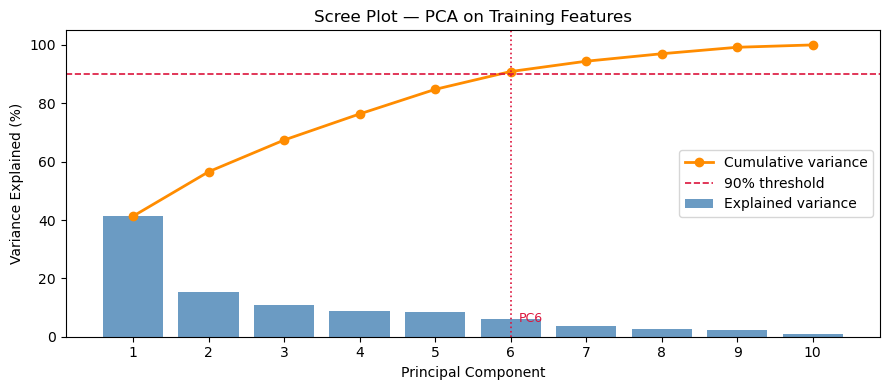

6 components explain ≥90% of variance  (90.9%)


In [45]:
# --- Cell 4: Scree Plot ---
evr = pca.explained_variance_ratio_
cumvar = np.cumsum(evr)
n_90 = np.searchsorted(cumvar, 0.90) + 1  # number of components for 90% variance

fig, ax = plt.subplots(figsize=(9, 4))
components = np.arange(1, len(evr) + 1)

ax.bar(components, evr * 100, color='steelblue', alpha=0.8, label='Explained variance')
ax.plot(components, cumvar * 100, 'o-', color='darkorange', lw=2, label='Cumulative variance')
ax.axhline(90, color='crimson', ls='--', lw=1.2, label='90% threshold')
ax.axvline(n_90, color='crimson', ls=':', lw=1.2)
ax.text(n_90 + 0.1, 5, f'PC{n_90}', color='crimson', fontsize=9)

ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
ax.set_title('Scree Plot — PCA on Training Features')
ax.set_xticks(components)
ax.legend()
plt.tight_layout()
plt.show()

print(f"{n_90} components explain ≥90% of variance  ({cumvar[n_90-1]*100:.1f}%)")

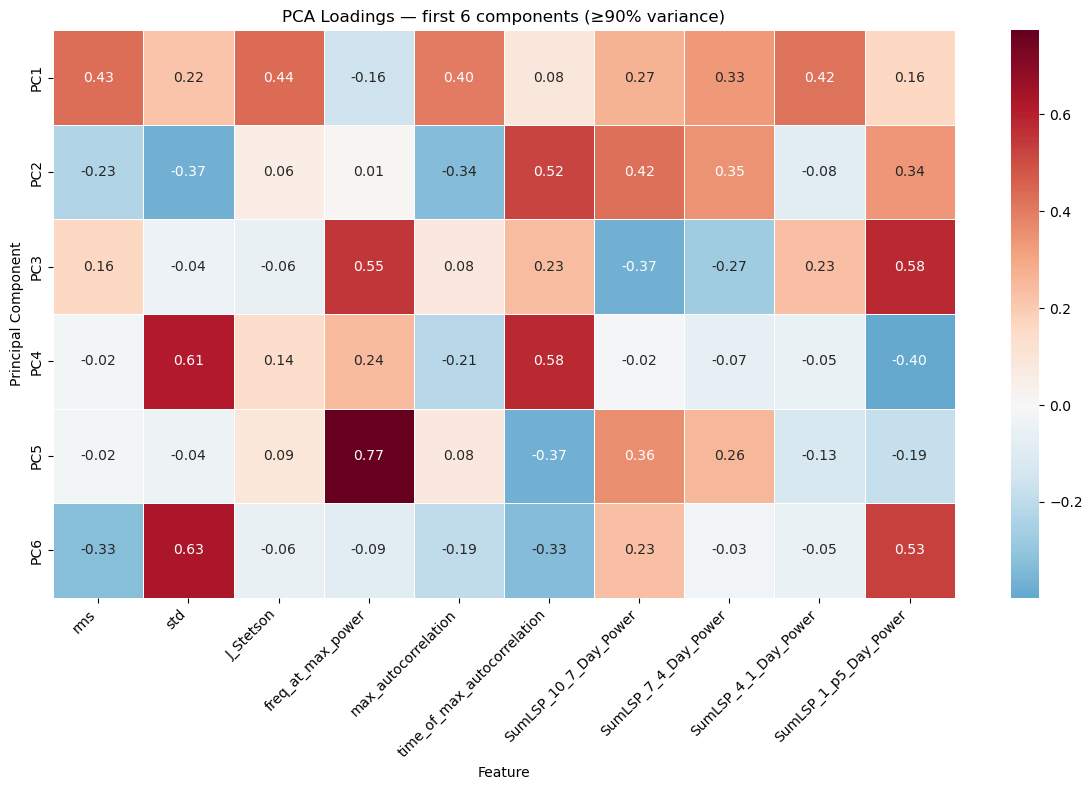

In [46]:
import seaborn as sns

# --- Cell 5: PCA Loadings Heatmap ---
loadings = pca.components_[:n_90, :]  # shape (n_90, n_features)

fig, ax = plt.subplots(figsize=(12, max(8, n_90 * 1)))
sns.heatmap(
    loadings,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    xticklabels=feature_cols,
    yticklabels=[f'PC{i+1}' for i in range(n_90)],
    linewidths=0.4,
    ax=ax,
)
ax.set_title(f'PCA Loadings — first {n_90} components (≥90% variance)')
ax.set_xlabel('Feature')
ax.set_ylabel('Principal Component')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

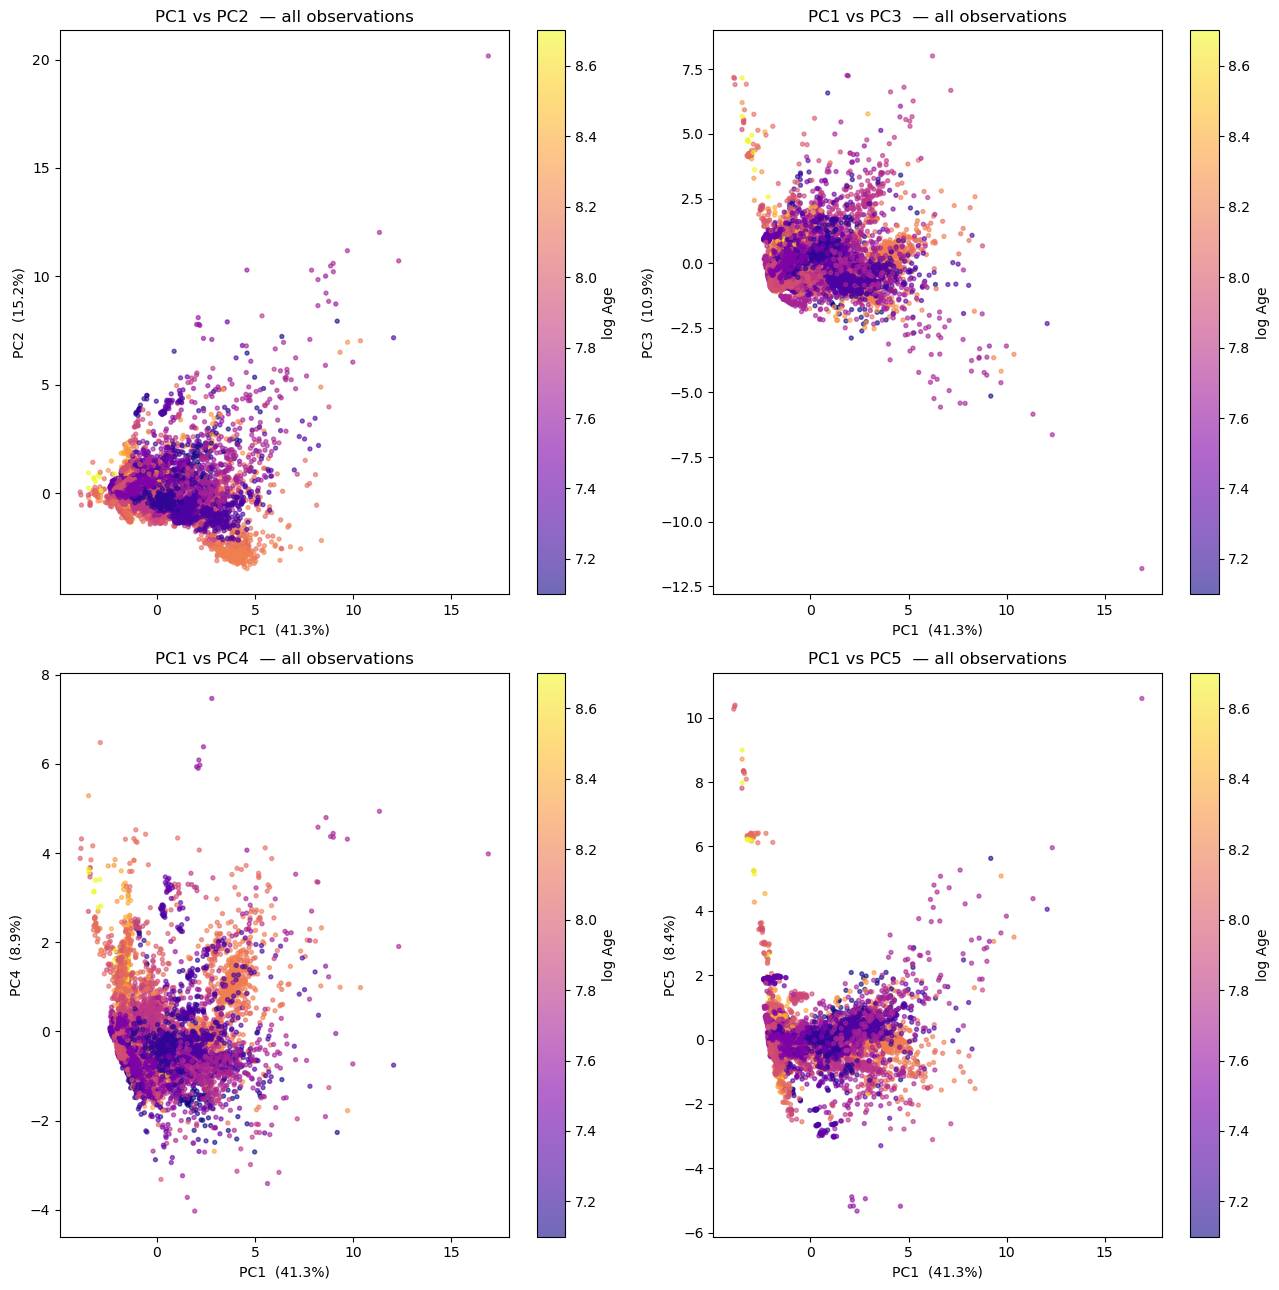

In [47]:
# --- Cell 6: Dataset in PCA Space (all observations, colored by age) ---
fig, axes = plt.subplots(2, 2, figsize=(13, 13))

for ax, (pc_x, pc_y) in zip(axes.flatten(), [(0, 1), (0, 2), (0, 3), (0, 4)]):
    sc = ax.scatter(X_pca[:, pc_x], X_pca[:, pc_y], c=y_np, cmap='plasma', s=8, alpha=0.6)
    plt.colorbar(sc, ax=ax, label='log Age')
    ax.set_xlabel(f'PC{pc_x+1}  ({evr[pc_x]*100:.1f}%)')
    ax.set_ylabel(f'PC{pc_y+1}  ({evr[pc_y]*100:.1f}%)')
    ax.set_title(f'PC{pc_x+1} vs PC{pc_y+1}  — all observations')

plt.tight_layout()
plt.show()

In [58]:
#cluster_pca

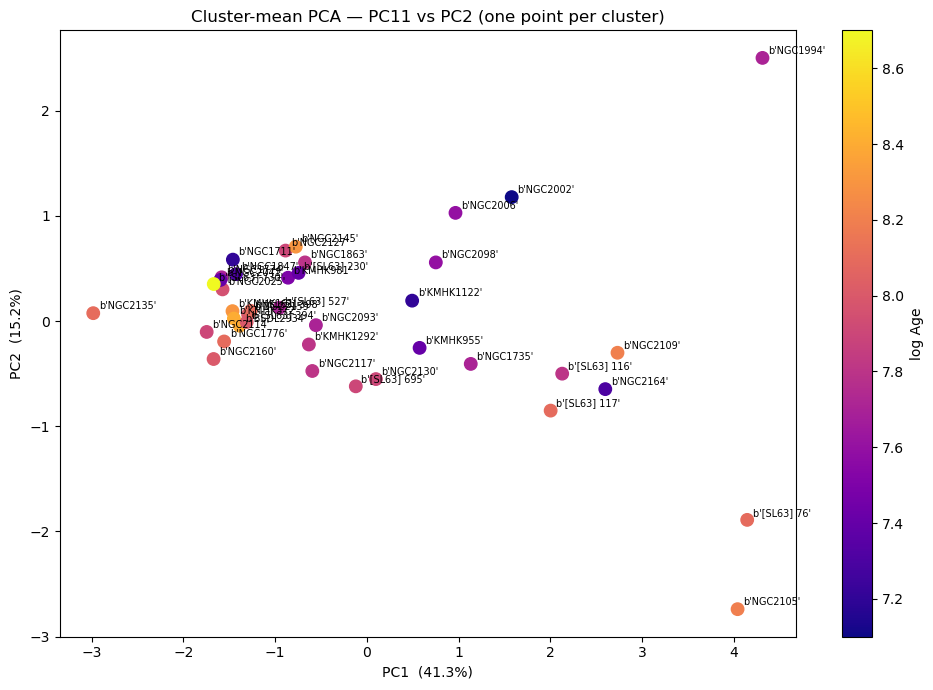

In [62]:
# --- Cell 7: Cluster-Level PCA (one point per cluster, colored by age) ---
unique_clusters = np.unique(train_cluster_names)
pc_x = 0
pc_y = 1

cluster_means = np.array([X_scaled[train_cluster_names == c].mean(axis=0) for c in unique_clusters])
cluster_ages  = np.array([y_np[train_cluster_names == c].mean() for c in unique_clusters])
cluster_pca   = pca.transform(cluster_means)

fig, ax = plt.subplots(figsize=(10, 7))
sc = ax.scatter(cluster_pca[:, pc_x], cluster_pca[:, pc_y], c=cluster_ages, cmap='plasma', s=80, zorder=3)
plt.colorbar(sc, ax=ax, label='log Age')

for i, name in enumerate(unique_clusters):
    ax.annotate(name, (cluster_pca[i, pc_x], cluster_pca[i, pc_y]),
                fontsize=7, xytext=(4, 3), textcoords='offset points')

ax.set_xlabel(f'PC1  ({evr[0]*100:.1f}%)')
ax.set_ylabel(f'PC2  ({evr[1]*100:.1f}%)')
ax.set_title(f'Cluster-mean PCA — PC1{pc_x+1} vs PC{pc_y+1} (one point per cluster)')
plt.tight_layout()
plt.show()

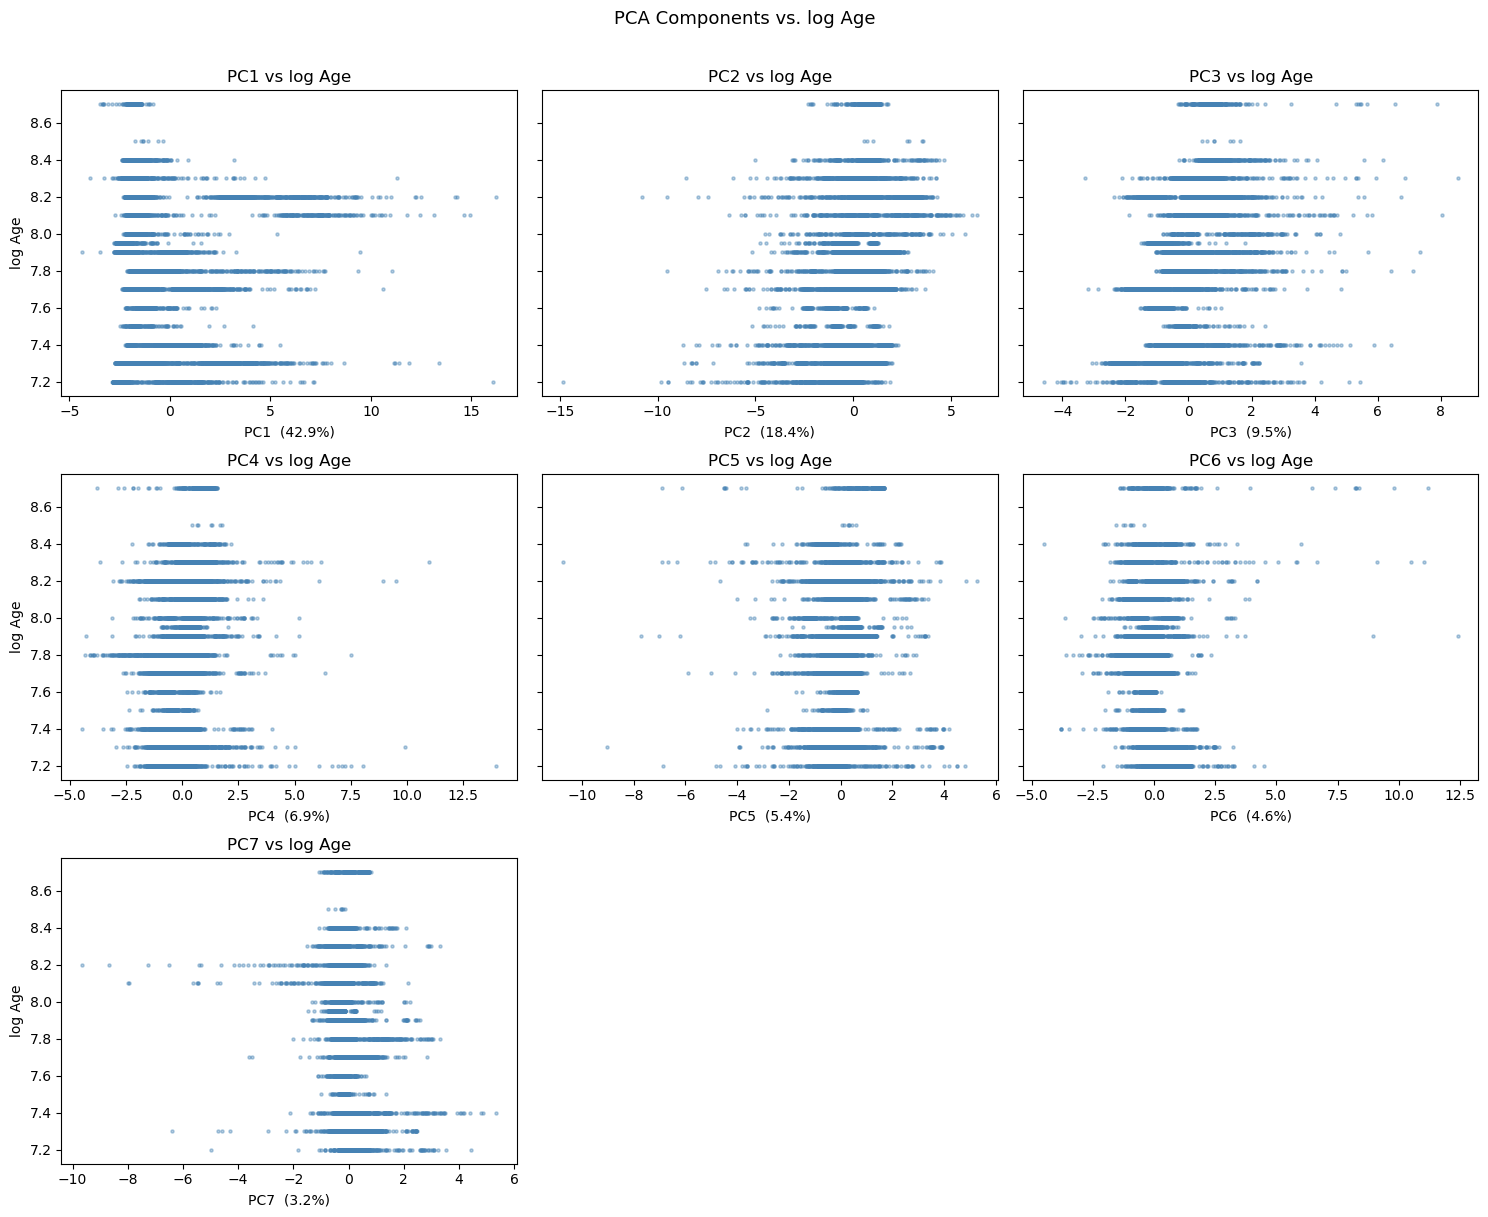

In [41]:
# --- Cell 8: Each PCA component vs. log Age ---
n_cols = 3
n_rows = int(np.ceil(n_90 / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

for i in range(n_90):
    ax = axes[i]
    ax.scatter(X_pca[:, i], y_np, s=5, alpha=0.4, color='steelblue')
    ax.set_xlabel(f'PC{i+1}  ({evr[i]*100:.1f}%)')
    ax.set_ylabel('log Age' if i % n_cols == 0 else '')
    ax.set_title(f'PC{i+1} vs log Age')

# Hide any unused subplots
for j in range(n_90, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('PCA Components vs. log Age', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

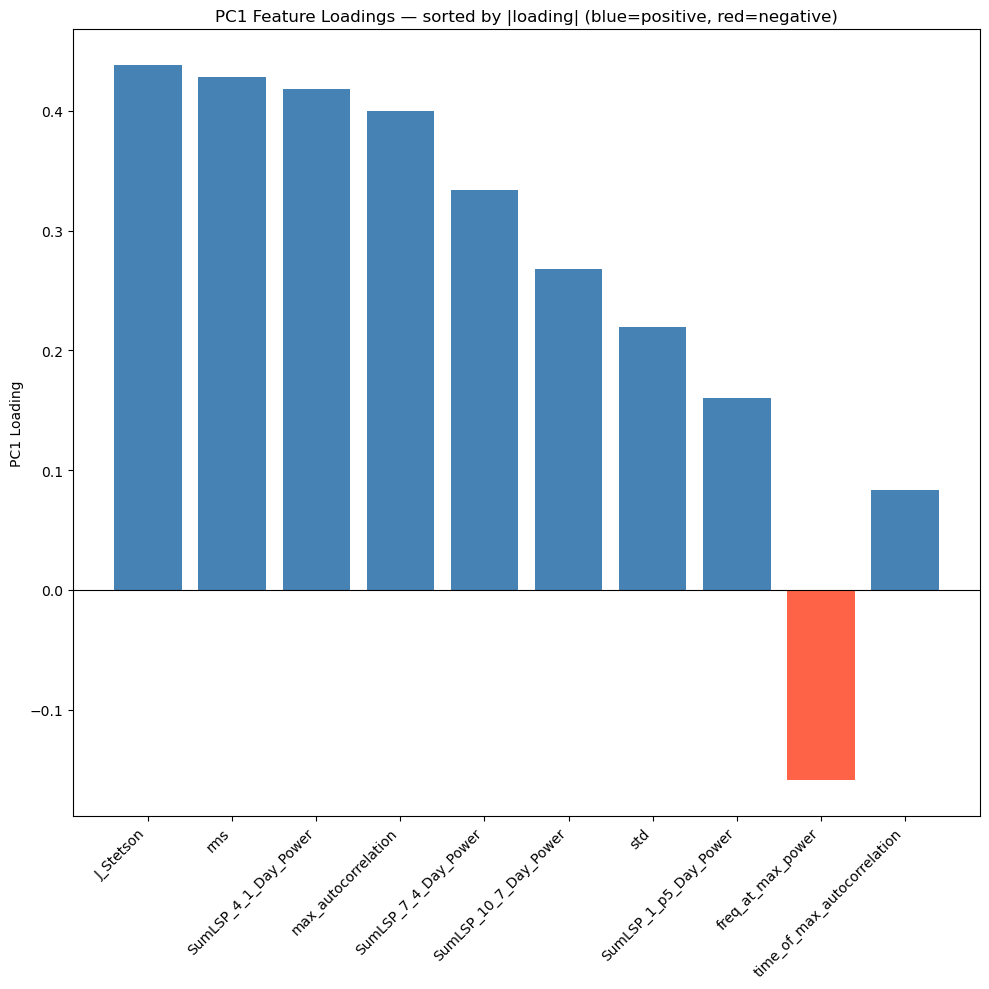

/tmp/ipykernel_71499/2769781507.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.89, 1])


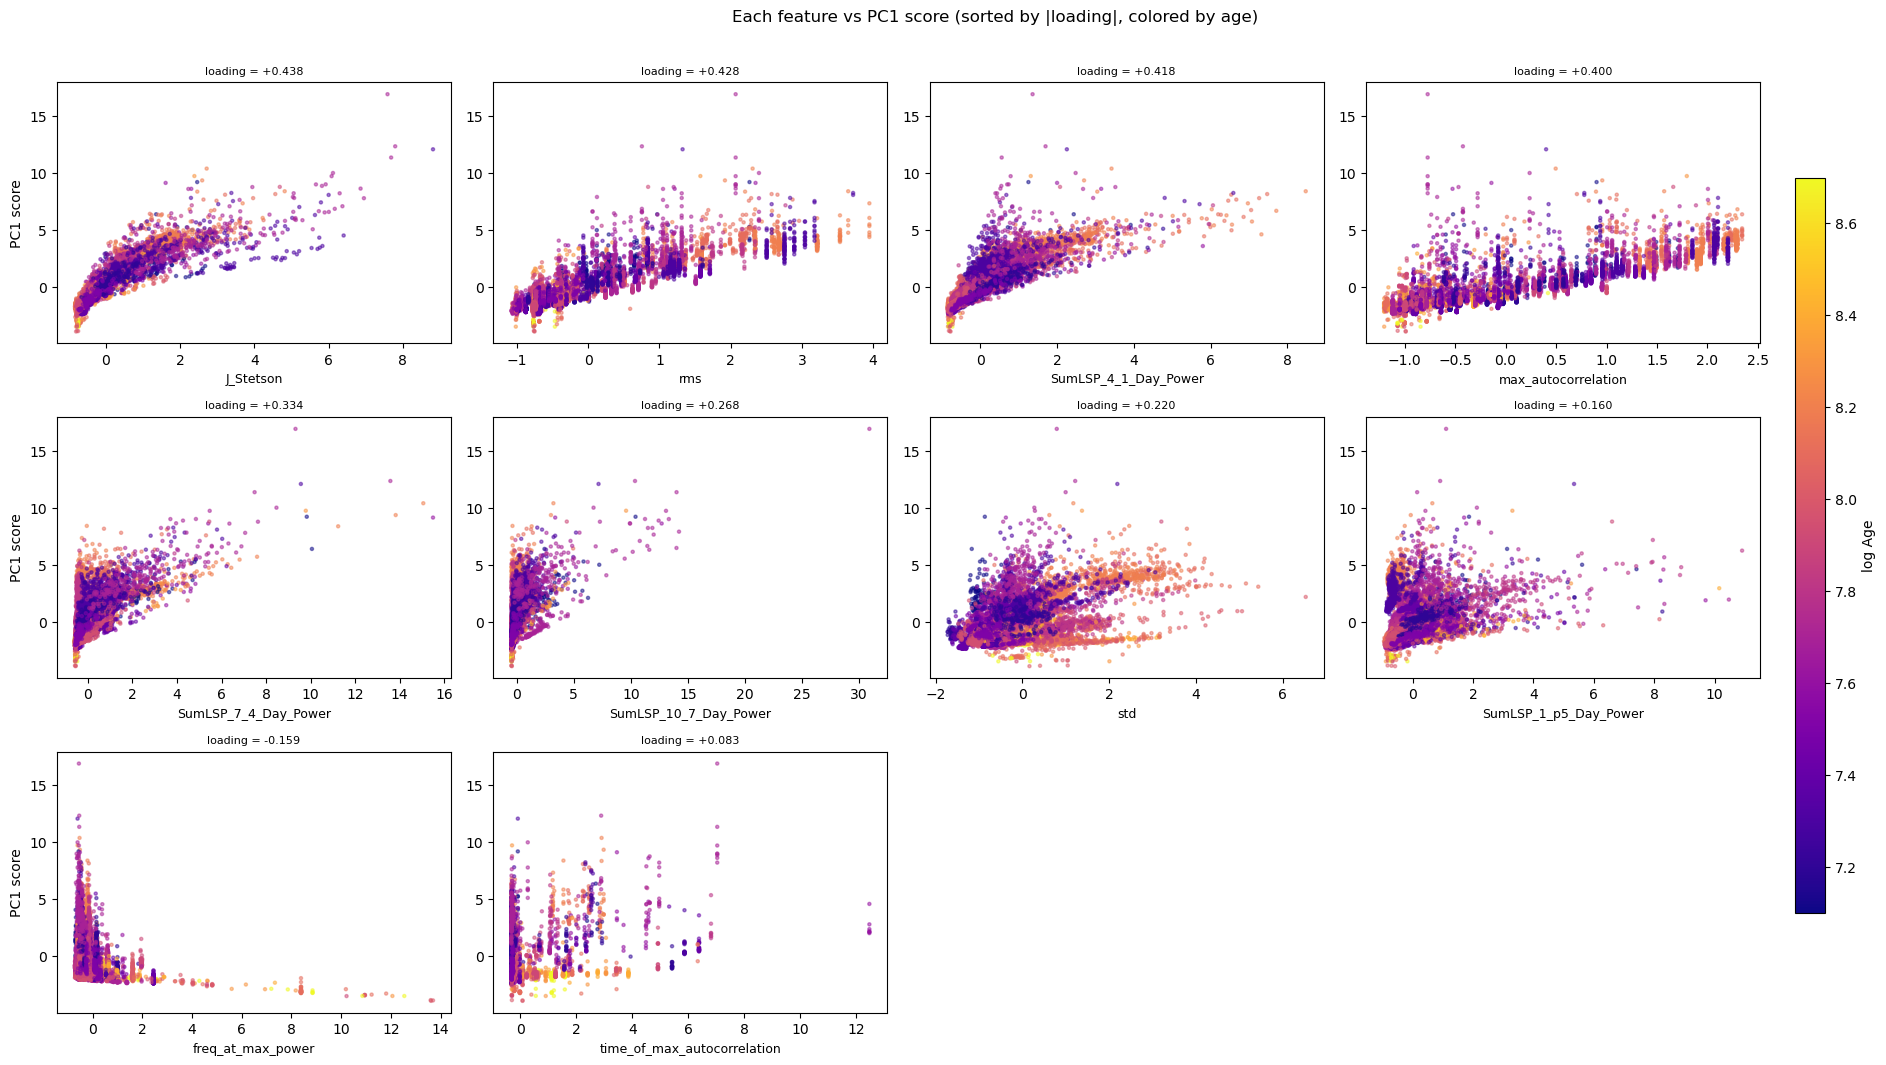

In [49]:
## --- Cell 9: PC1 Diagnostic — what drives the first component? ---
pc1_loadings = pca.components_[0]        # shape (n_features,)
pc1_scores   = X_pca[:, 0]              # shape (n_obs,)

# Sort features by absolute loading magnitude (largest driver first)
sort_idx = np.argsort(np.abs(pc1_loadings))[::-1]
sorted_features  = [feature_cols[i] for i in sort_idx]
sorted_loadings  = pc1_loadings[sort_idx]

# --- Top panel: loading bar chart ---
fig, ax = plt.subplots(figsize=(10, 10))
colors = ['steelblue' if v > 0 else 'tomato' for v in sorted_loadings]
ax.bar(sorted_features, sorted_loadings, color=colors)
ax.axhline(0, color='k', lw=0.8)
ax.set_ylabel('PC1 Loading')
ax.set_title('PC1 Feature Loadings — sorted by |loading| (blue=positive, red=negative)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Bottom panel: each feature vs PC1 score, colored by age ---
n_cols = 4
n_rows = int(np.ceil(len(feature_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for k, idx in enumerate(sort_idx):          # iterate in loading-magnitude order
    ax = axes[k]
    sc = ax.scatter(X_scaled[:, idx], pc1_scores, c=y_np, cmap='plasma', s=5, alpha=0.5)
    ax.set_xlabel(feature_cols[idx], fontsize=9)
    ax.set_ylabel('PC1 score' if k % n_cols == 0 else '')
    loading_val = pc1_loadings[idx]
    ax.set_title(f'loading = {loading_val:+.3f}', fontsize=8)

for j in range(len(feature_cols), len(axes)):
    axes[j].set_visible(False)

# Single shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap='plasma',
                            norm=plt.Normalize(vmin=y_np.min(), vmax=y_np.max()))
fig.colorbar(sm, cax=cbar_ax, label='log Age')

fig.suptitle('Each feature vs PC1 score (sorted by |loading|, colored by age)', y=1.01, fontsize=12)
plt.tight_layout(rect=[0, 0, 0.89, 1])
plt.show()

/tmp/ipykernel_71499/3384758556.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.89, 1])


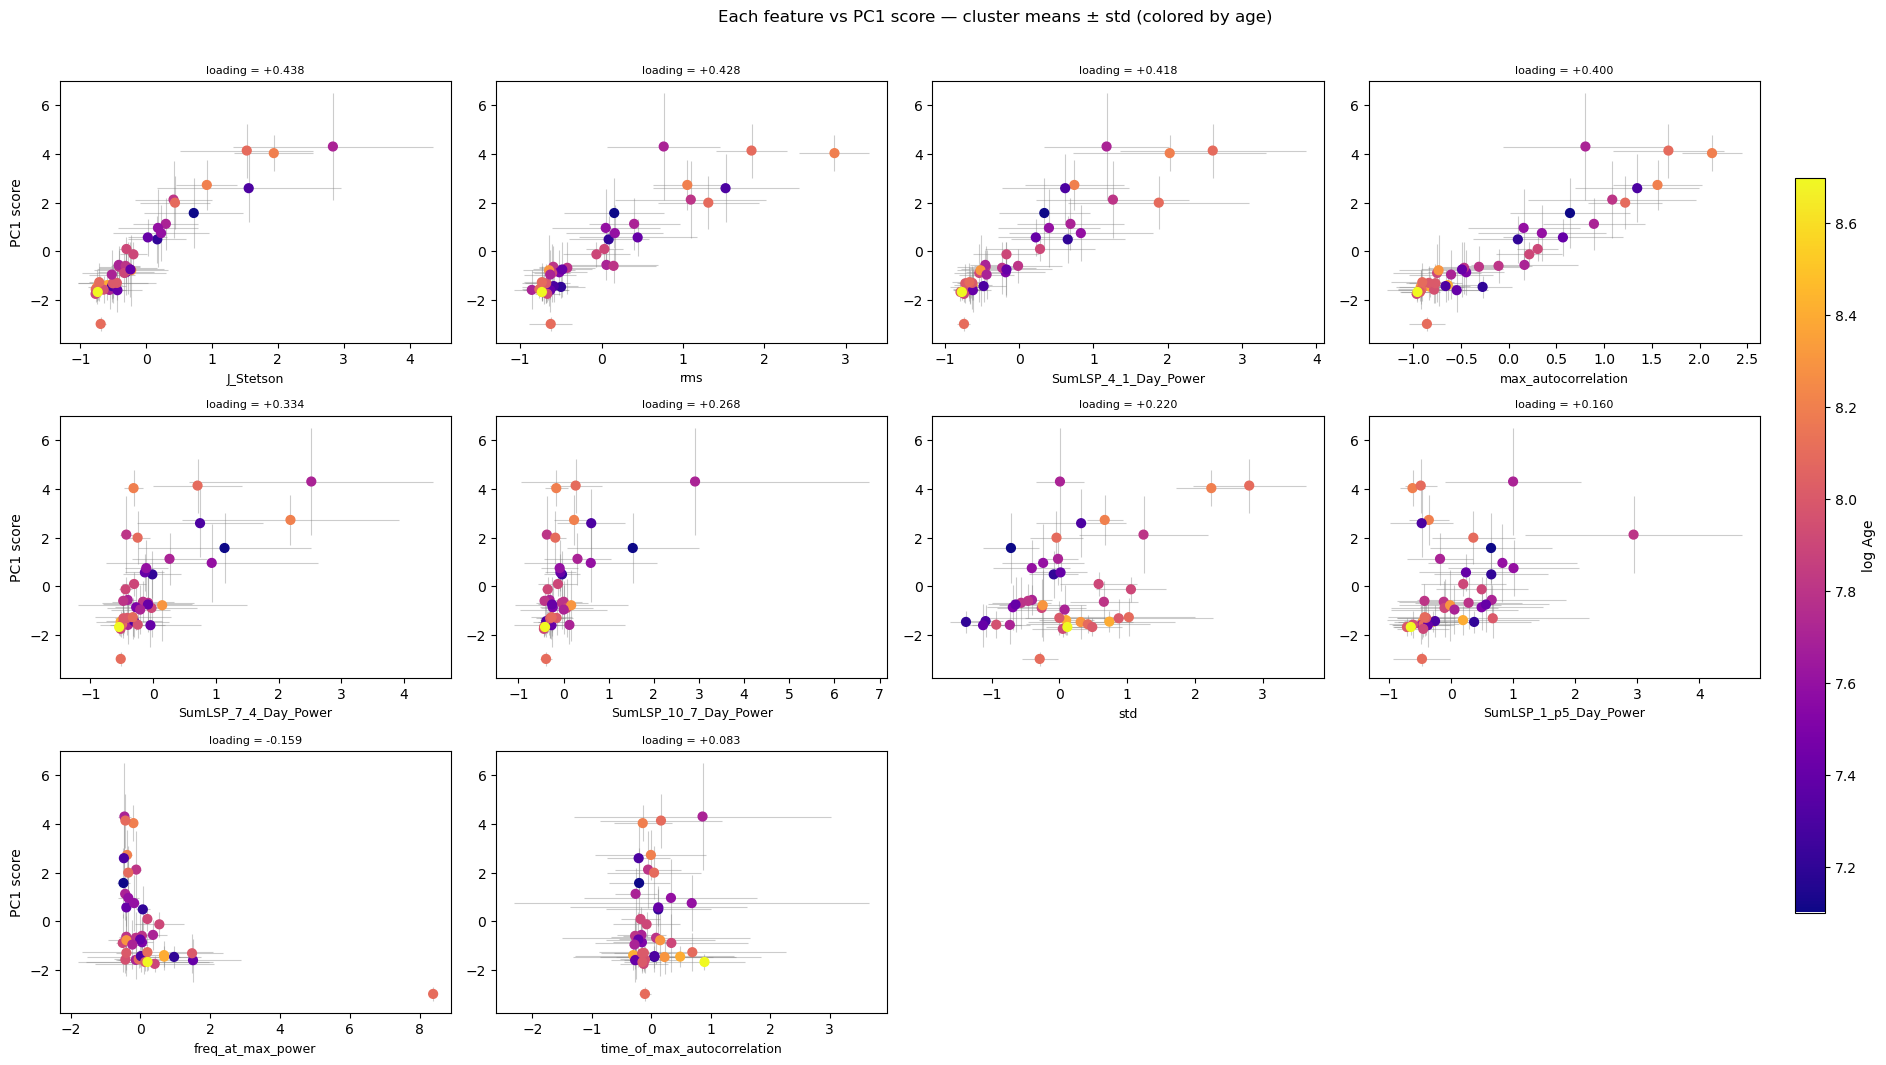

In [50]:
# --- Cell 10: PC1 Diagnostic — cluster-level (mean ± std per cluster) ---
unique_clusters = np.unique(train_cluster_names)

# Aggregate to per-cluster mean and std
c_feat_mean = np.array([X_scaled[train_cluster_names == c].mean(axis=0) for c in unique_clusters])  # (n_clusters, n_features)
c_feat_std  = np.array([X_scaled[train_cluster_names == c].std(axis=0)  for c in unique_clusters])
c_pc1_mean  = np.array([pc1_scores[train_cluster_names == c].mean()      for c in unique_clusters])
c_pc1_std   = np.array([pc1_scores[train_cluster_names == c].std()       for c in unique_clusters])
c_ages      = np.array([y_np[train_cluster_names == c].mean()            for c in unique_clusters])

norm_age = plt.Normalize(vmin=c_ages.min(), vmax=c_ages.max())
cmap     = plt.cm.plasma

n_cols = 4
n_rows = int(np.ceil(len(feature_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for k, idx in enumerate(sort_idx):      # same sort order as cell 9
    ax = axes[k]
    colors = cmap(norm_age(c_ages))

    ax.errorbar(
        c_feat_mean[:, idx], c_pc1_mean,
        xerr=c_feat_std[:, idx], yerr=c_pc1_std,
        fmt='none', ecolor='gray', alpha=0.4, lw=0.8, zorder=1,
    )
    sc = ax.scatter(c_feat_mean[:, idx], c_pc1_mean,
                    c=c_ages, cmap='plasma', s=40, zorder=2,
                    norm=norm_age)

    ax.set_xlabel(feature_cols[idx], fontsize=9)
    ax.set_ylabel('PC1 score' if k % n_cols == 0 else '')
    ax.set_title(f'loading = {pc1_loadings[idx]:+.3f}', fontsize=8)

for j in range(len(feature_cols), len(axes)):
    axes[j].set_visible(False)

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])
fig.colorbar(plt.cm.ScalarMappable(norm=norm_age, cmap='plasma'),
             cax=cbar_ax, label='log Age')

fig.suptitle('Each feature vs PC1 score — cluster means ± std (colored by age)', y=1.01, fontsize=12)
plt.tight_layout(rect=[0, 0, 0.89, 1])
plt.show()